# P versus NP problem

The P vs NP problem constitutes one of the biggest questions in Computational Theory, being also a Million Prize Problem. It asks whether every problem whose solution can be verified in polynomial time can also be solved in polynomial time.

In Computational Complexity Theory, a *decision problem* is a problem with a yes or no answer. **NP** is a complexity class that represents the set of decision problems in which it can be checked in a reasonable time whether a solution of the problem is valid or not. However, it requires a *nondeterministic polynomial time* to find a solution to the problem. 

Otherwise, __P__ is a complexity class that represents the set of decision problems for which it can be found a solution in a *polynomial time*. It is easy to see that a problem p belongs to np but not the other way around. 

__NP-complete__ are the most difficult problems in NP, in the sense that they are the most probable to not be included in P. A decisión problem $c$ is said to be NP-complete if:
<ol>
    <li> $c$ i in NP.
    <li> Every problem in NP is reducible to $c$ in polynomial time.
</ol>
If every NP-complete problem was included in P, then it will indicate that:
\begin{equation}
P = NP.
\end{equation}

Finally, a problem H is **NP-hard** when every problem L in NP can be reduced in polynomial time to H; that is, assuming a solution for H takes 1 unit time, we can use H's solution to solve L in polynomial time. As a consequence, finding a polynomial algorithm to solve any NP-hard problem would give polynomial algorithms for all the problems in NP, which is unlikely as many of them are considered difficult. Note that NP-hard problems do not have to be in NP, and they do not have to be decision problems. [1][2]

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/P_np_np-complete_np-hard.svg/800px-P_np_np-complete_np-hard.svg.png" width="500" height="500">

Some examples of NP-complete problems are *exact cover*, *max-cut* and *3-SAT*. The *exact cover* will be studied in the following section.

## Exact cover

Given a finite nonempty set $U = \{u_1, ..., u_n\}$, also called universe, and a family $F = \{S_1, ..., S_m\}$ of $m \geq 1$ nonempty subsets of $U$. Then the question is whether there is an *exact cover*, which is a subfamily $C \subseteq F$ of subsets in $F$ such that the sets in $C$ are disjoint and their union is equal to $U$.

For example, suppose the finite set:

\begin{equation}
U = \{u_1, u_2, u_3, u_4, u_5, u_6\}
\end{equation}

and let $F$ be the family:

\begin{equation}
F = \{\{u_1, u_3\}, \{u_2, u_3, u_6\},  \{u_1, u_5\}, \{u_2, u_3, u_4\}, \{u_5, u_6\}, \{u_2, u_4\}\}
\end{equation}

Then, the subfamily $C$ defined as:

\begin{equation}
C = \{\{u_1, u_3\}, \{u_5, u_6\}, \{u_2, u_4\}\}
\end{equation}

is an exact cover. [4]

### The example problem

The main goal is to find the exact cover (if it exists) for the following set:

In [1]:
import numpy as np
import json
from qiskit import Aer
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import exact_cover
from qiskit.aqua.algorithms import ExactEigensolver

input_file = 'sample.exactcover'
#with open(input_file) as f:
    #Import the dataset and form a list with it
    #list_of_subsets = json.load(f)
    #print(list_of_subsets)
    
list_of_subsets = [[1, 3], [2, 3, 6], [1, 5], [2, 3, 4], [5, 6], [2, 4]]
print(list_of_subsets)

[[1, 3], [2, 3, 6], [1, 5], [2, 3, 4], [5, 6], [2, 4]]


For that purpose the problem will be faced in different ways:
<ol>
    <li> Brute-force method.
    <li> Optimization in the non-programming way.
    <li> Optimization in the programming way.
    <li> Optimization with the Variational-Quantum-Eigensolver (VQE).
</ol>

Other algorithms have been used to solve this problem, highlighting "Algorithm X" by Donald Knuth. [5]

In order to solve the problem a Hamiltonian of the system should be defined. For the exact cover problem, the objective is to find a subfamily where each element appears only once and that the union of the sets forms the universe. So we look for a Hamiltonian that presents its ground state for the exact cover set:

\begin{equation}
H = \sum_{element} \left( 1 - \sum\limits_{\substack{subset ~i ~that\\ includes ~ element}} X_i \right)^2 
\end{equation}

where $X_i$ is an operator which takes eigenvalues:

\begin{equation}
x_i = \begin{cases}
      0 ~;~ if ~subset ~i ~is ~not ~included\\
      1 ~;~ if ~subset ~i ~is ~included
      \end{cases}
\end{equation}

It is clear that this Hamiltonians ground state represents the solution of the exact cover problem, so now the task reduces to find the algorithms necessary to find the ground state of a given Hamiltonian, which could be degenerated if several exact covers are possible.

In [2]:
#Construct the Hamiltonian operator of the problem (qubitOp) and a constant shift of the eigevalues (offset).
#For our purpose it will create 4 qubits, as many as subsets in the family.
qubitOp, offset = exact_cover.get_exact_cover_qubitops(list_of_subsets)
#Generate a class (algo_input) which given an operator prepares the entry for the run_algorithm function: operator instance
algo_input = EnergyInput(qubitOp)

#### 1. Brute-froce method
This method does not require a Hamiltonian and it basically consists in exhaustively try all the binary assignments. In each binary assignment, the entry of a subset is either 0 (meaning the subset is not in the cover) or 1 (meaning the subset is in the cover). We print the binary assignment that satisfies the definition of the exact cover.

In [3]:
def brute_force():
    # brute-force way: try every possible assignment!
    has_sol = False

    #First define a function which transforms a integer to a list whose elements are the binary digits of the number
    def bitfield(n, L):
        result = np.binary_repr(n, L)
        return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

    L = len(list_of_subsets)
    max = 2**L
    #Try every possible combination and check if it is an exact cover
    for i in range(max):
        cur = bitfield(i, L)
        cur_v = exact_cover.check_solution_satisfiability(cur, list_of_subsets)
        if cur_v:
            has_sol = True
            break
    return has_sol, cur

from time import time
t = time()
has_sol, cur = brute_force()
print(time()-t)

if has_sol:
    print("Solution is", cur)
else:
    print("No solution is found")

0.0029942989349365234
Solution is [1, 0, 0, 0, 1, 1]


#### 2. Optimization in the non-programming way.

In [4]:
#Define the params of the problem and the algorithm which is going to be used for solving it. In this case, as it is wanted
#to find the eigenvalues of the Hamiltonian defined we require the 'ExactEigensolver' algorithm. As no other argument is 
#introduced in ExactEigensolver it will only find the ground state.
params = {
    'problem': {'name': 'ising'},
    'algorithm': {'name': 'ExactEigensolver'}
}
#Now the algorithm is run to find the eigenvalues and eigenvectors of the Hamiltonian.

t = time()
result = run_algorithm(params, algo_input)
print(time()-t)

print(result)
#Next, the most likely binary string from state vector is computed.
x = exact_cover.sample_most_likely(len(list_of_subsets), result['eigvecs'][0])

#Then we get the solution from the x array taking into account that qubit states are placed in the inverse order.
ising_sol = exact_cover.get_solution(x)

#Finally the solution is checked
#np.testing.assert_array_equal(ising_sol, [0, 1, 1, 0])
if exact_cover.check_solution_satisfiability(ising_sol, list_of_subsets):
    print("Solution is", ising_sol)
else:
    print("No solution is found")

13.277311563491821
{'eigvals': array([-4.]), 'eigvecs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'energy': -4.0, 'wavefunction': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'energies': array([-4.])}
Solution is [1. 0. 0. 0. 1. 1.]


#### 3. Optimization in the programming way

In [5]:
#Run the algorithm used to find k eigenvalues of the operator given with no auxiliar operators. In our case, as we only want
#to find the ground state k will take the value 1.
algo = ExactEigensolver(qubitOp, k=1, aux_operators=[])
t = time()
result = algo.run()
print(time()-t)
#Next, the most likely binary string from state vector is computed.
x = exact_cover.sample_most_likely(len(list_of_subsets), result['eigvecs'][0])

#Then we get the solution from the x array taking into account that qubit states are placed in the inverse order.
ising_sol = exact_cover.get_solution(x)

#Finally the solution is checked
#np.testing.assert_array_equal(ising_sol, [0, 1, 1, 0])

if exact_cover.check_solution_satisfiability(ising_sol, list_of_subsets):
    print("Solution is", ising_sol)
else:
    print("No solution is found")

0.0
Solution is [1. 0. 0. 0. 1. 1.]


#### 4. Optimization with the Variational-Quantum-Eigensolver (VQE)

The Variational-Quantum-Eigensolver (VQE) is a quantum/classical hybrid algorithm used to find the eigenvalues of a matrix $H$. In this hybrid algorithm a quantum subroutine is run inside of a classical optimization loop. [6]

The quantum subroutine has two fundamental steps:
<ol>
    <li> Prepare the quantum state $|\psi(\vec{\theta})⟩$, often called the ansatz.
    <li> Measure the expectation value: $\langle \psi(\vec{\theta}) | H | \psi(\vec{\theta}) \rangle$
</ol>

From the variational principle we know that this expectation value is always greater that the ground state of $H$. This bound allows us to use classical computation to run an optimization loop to find this eigenvalue:
<ol>
    <li> Use a classical non-linear optimizer to minimize the expectation value by varying ansatz parameters $\vec{\theta}$.
    <li> Iterate until convergence.
</ol>

In [6]:
#The Variational-Quantum-Eigensolver (VQE) algorithm is selected

algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'paulis'
}

#Constrained optimization by linear approximation (COBYLA) is a numerical optimization method for constrained problems 
#where the derivative of the objective function is not known.
#https://en.wikipedia.org/wiki/COBYLA

optimizer_cfg = {
    'name': 'COBYLA'
}

#The RyRz trial wave function is layers of y plus z rotations with entanglements.
#https://qiskit.org/documentation/aqua/variational_forms.html

var_form_cfg = {
    'name': 'RYRZ',
    'depth': 2,
    'entanglement' : "full"
}

#Now the params are defined
params = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg
}

#Finally we use the 'statevector_simulator' backend to simulate
backend = Aer.get_backend('statevector_simulator')
result = run_algorithm(params, algo_input, backend=backend)
x = exact_cover.sample_most_likely(len(list_of_subsets), result['eigvecs'][0])
ising_sol = exact_cover.get_solution(x)
if exact_cover.check_solution_satisfiability(ising_sol, list_of_subsets):
    print("Solution is", ising_sol)
else:
    print("No solution is found")
print('Time (s):', result['eval_time'])
print('Energy:', result['energy'] + offset)
print('Number of evaluations:', result['eval_count'])

Solution is [1. 0. 0. 0. 1. 1.]
Time (s): 84.02626156806946
Energy: 1.888090119805952e-07
Number of evaluations: 1000


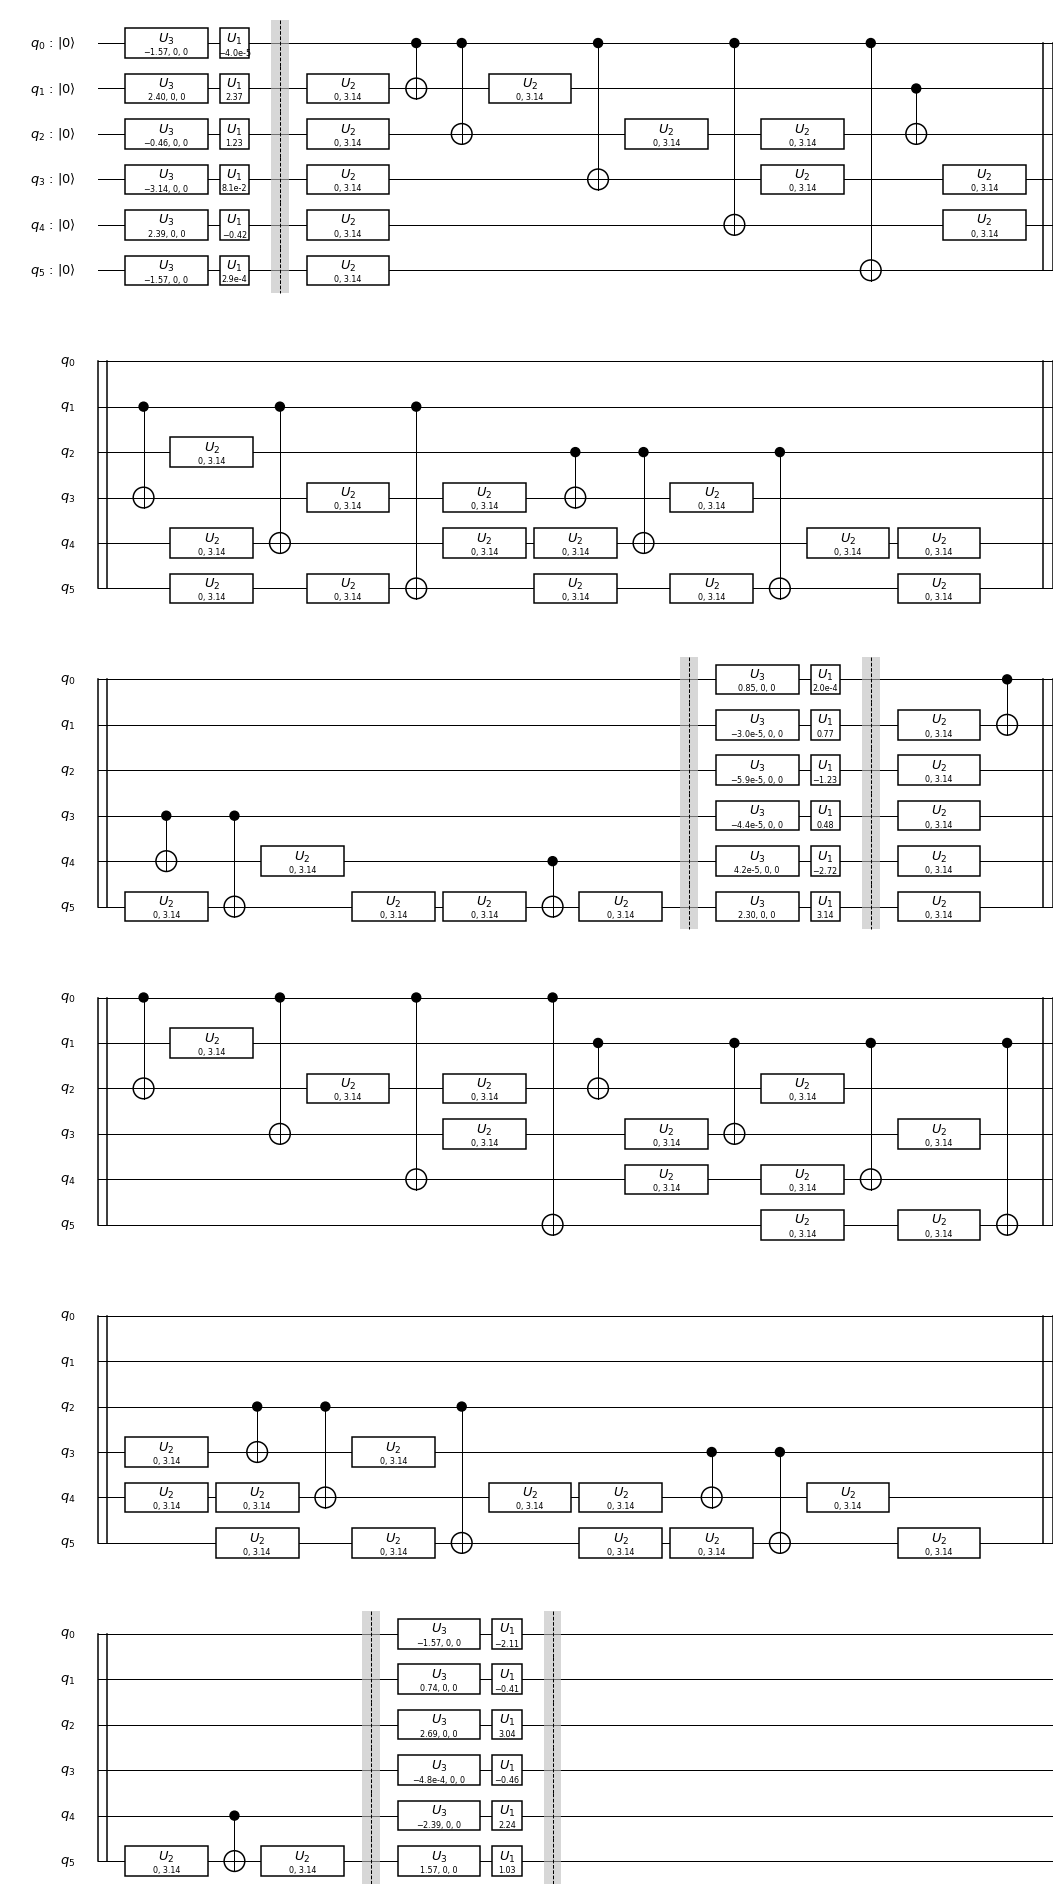

In [7]:
from qiskit.aqua.components.variational_forms.ry import RY
from qiskit.aqua.components.variational_forms.ryrz import RYRZ

import numpy as np

num_qubits = len(list_of_subsets)
depth = var_form_cfg['depth']
entanglement = var_form_cfg['entanglement']
type_of_variation = var_form_cfg['name']

if type_of_variation == 'RY':
    circ = RY(num_qubits, depth=depth, entanglement=entanglement)
elif type_of_variation == 'RYRZ':
    circ = RYRZ(num_qubits, depth=depth, entanglement=entanglement)

circ_parameters = result['opt_params']
qc = circ.construct_circuit(circ_parameters)

qc.draw(output='mpl', filename='exact_cover.png')

## Bibliography

https://stackoverflow.com/questions/1857244/what-are-the-differences-between-np-np-complete-and-np-hard

**[1]** Sipser, M. (1992, July). The history and status of the P versus NP question. In Proceedings of the twenty-fourth annual ACM symposium on Theory of computing (pp. 603-618). ACM.

**[2]** NP-Completeness | Set 1 (Introduction). (2018, September 07). Retrieved from https://www.geeksforgeeks.org/np-completeness-set-1/

**[3]** P versus NP problem. (2019, January 13). Retrieved from https://en.wikipedia.org/wiki/P_versus_NP_problem

**[4]** UNIVERSITY OF PENNSYLVANIA, S. (2017). Chapter 10. Some NP-Complete Problems.

**[5]** Exact Cover Problem and Algorithm X | Set 1. (2018, February 15). Retrieved from https://www.geeksforgeeks.org/exact-cover-problem-algorithm-x-set-1/

**[6]** Variational-Quantum-Eigensolver (VQE)¶. (n.d.). Retrieved from https://grove-docs.readthedocs.io/en/latest/vqe.html

**[7]** Qiskit. (2019, February 11). Qiskit/qiskit-tutorials. Retrieved from https://github.com/Qiskit/qiskit-tutorials